In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Will a Player get Drafted?

# Why use a Decision Tree?

Here we are going to build a model that predicts whether or not a player will be drafted based on their combine performance (a binary outcome). Decision Trees are often used forbinary classification tasks because they are relatively easy to interpret and can handle a large number of input features. Additionally, they bring insight to feature importance, which can be useful for understanding which input features are most relevant to the prediction of the binary outcome and can guide future decisions!

# We will start by ingesting the data

In [11]:
master_table = master_table = pd.read_csv("NFL.csv")
master_table.head()

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes


### Let's take a surface level look

In [16]:
master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 3477 non-null   int64  
 1   Player               3477 non-null   object 
 2   Age                  2927 non-null   float64
 3   School               3477 non-null   object 
 4   Height               3477 non-null   float64
 5   Weight               3477 non-null   float64
 6   Sprint_40yd          3303 non-null   float64
 7   Vertical_Jump        2780 non-null   float64
 8   Bench_Press_Reps     2572 non-null   float64
 9   Broad_Jump           2749 non-null   float64
 10  Agility_3cone        2260 non-null   float64
 11  Shuttle              2337 non-null   float64
 12  Drafted..tm.rnd.yr.  2254 non-null   object 
 13  BMI                  3477 non-null   float64
 14  Player_Type          3477 non-null   object 
 15  Position_Type        3477 non-null   o

For this model we only want to look at combine "performance" metrics, not attributes such as height, weight, etc. So let's filter the columns out that we want to use as features.

In [21]:
master_table = master_table[['Year','Player','School','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','Player_Type','Position_Type','Position','Drafted']]
master_table                          

,Year,Player,School,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,Ohio St.,4.38,85.09,25.0,325.12,NaN,NaN,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,Illinois,4.84,83.82,27.0,292.10,7.38,4.45,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,LSU,5.50,NaN,21.0,NaN,NaN,NaN,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,Alabama,4.49,93.98,15.0,304.80,7.09,4.23,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,Connecticut,4.76,92.71,26.0,304.80,7.10,4.40,defense,line_backer,OLB,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,2019,Xavier Crawford,Central Michigan,4.48,95.25,11.0,NaN,NaN,NaN,defense,defensive_back,CB,No
3473,2019,Jordan Brown,South Dakota St.,4.51,100.33,13.0,325.12,NaN,NaN,defense,defensive_back,CB,No
3474,2019,Corey Ballentine,Washburn,4.47,100.33,15.0,342.90,6.82,4.14,defense,defensive_back,CB,No
3475,2019,Ugo Amadi,Oregon,4.51,82.55,18.0,292.10,7.21,4.19,defense,defensive_back,S,No


### Prepare for the Decision Tree

For our feature selection we are going to take the 6 combine performance metrics ('Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle').
We will then separate these input features from the outcome variable (Here: Whether or not a player was drafted). 

We do this by separating the data into a Feature dataframe (X) and a Series containing the binary classification (Y).

In [31]:
X = master_table.iloc[:,3:9]
Y = master_table.iloc[:,-1]

In [32]:
#Features
X

,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle
0,4.38,85.09,25.0,325.12,NaN,NaN
1,4.84,83.82,27.0,292.10,7.38,4.45
2,5.50,NaN,21.0,NaN,NaN,NaN
3,4.49,93.98,15.0,304.80,7.09,4.23
4,4.76,92.71,26.0,304.80,7.10,4.40
...,...,...,...,...,...,...
3472,4.48,95.25,11.0,NaN,NaN,NaN
3473,4.51,100.33,13.0,325.12,NaN,NaN
3474,4.47,100.33,15.0,342.90,6.82,4.14
3475,4.51,82.55,18.0,292.10,7.21,4.19


In [34]:
# Classfication
Y

0       Yes
1       Yes
2       Yes
3       Yes
4       Yes
       ... 
3472     No
3473     No
3474     No
3475     No
3476     No
Name: Drafted, Length: 3477, dtype: object

### As always, we need to do some data cleaning

In [37]:
X.isnull().sum()

Sprint_40yd          174
Vertical_Jump        697
Bench_Press_Reps     905
Broad_Jump           728
Agility_3cone       1217
Shuttle             1140
dtype: int64

There are several ways to "handle" null values. In this exercise, I do not want to focus on cleaning as much as the thought and fundamentals of a decision tree, so we will simply drop the records containing null values here. This is not something I advise as best practice. Over the course, as we get into more advanced concepts and projects, I will go over handling null values more thoroughly.

In [42]:
#Drop Records Containing Null Values
X.dropna(inplace=True)  
X.isnull().sum() #Check

Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
dtype: int64

Now we have to remove the SAME records from the Y series. Since both X and Y have retained their index, we can use them to match records!

In [45]:
Y = Y[Y.index.isin(X.index)]

Now obviously, the lengths of X and Y should be the same and let's check that:

In [49]:
print("Length X:", len(X))
print("Length Y:", len(Y))

Length X: 1731
Length Y: 1731


### "Split" the data into training and testing sets

This is a technique used in machine learning algorithms in order to evaluate the performance of a model without bias.


__The training set__ is the portion of the data that is used to train the machine learning model. In this dataset, the model "knows" the outcome (it is presented with the output label from Y), and it will use this information to "fit" a model that will be able to generalize to new and "unseen" data.

__The test set__ is used to evaluate how well the trained model performs on new, unseen data. The testing data includes both input data and corresponding output labels, but the output labels are __not__ used during testing. Instead, the model makes predictions on the testing data, and the predicted outputs are compared to the actual outputs to evaluate the model's performance.

sklearn has a built in function to help us do this: train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state=100)

What is this doing? It is taking 30% (0.3) of the data and assigning it to the "test" set. A 70/30 or 80/20 split are usually the most common and considered the gold standard for splitting. The "random_state" assignment is used so that you can get the same "random" split in the future for reproducibility or debugging. 

#### So what do we have now?

In [55]:
print("X_train Length", len(X_train))
print("X_test Length", len(X_test))
print("y_train Length", len(y_train))
print("y_test Length", len(y_test))

X_train Length 1211
X_test Length 520
y_train Length 1211
y_test Length 520


The split worked and we are ready to train our model!

## Training and Evaluating the Model

We will use the DecisionTreeClassifier in sklearn. The first step is to create an instance of the class and specify any hyperparameters you want to use. Some of the commonly used hyperparameters include:
- __max_depth__: the maximum depth of the decision tree
- __min_samples_split__: the minimum number of samples required to split an internal node
- __criterion__: the function used to measure the quality of a split (e.g., 'gini' or 'entropy')

We will not use more than this for now. And I encourage you to read the sklearn documentation for more info!
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [62]:
clf = DecisionTreeClassifier(criterion = 'gini',min_samples_split = 3, max_depth = 3)

We then need to "fit" the model on the training data

In [63]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=3)

#### Let's now try to "Predict" on our test data!

In [65]:
y_pred = clf.predict(X_test)

#### And to evaluate

In [72]:
print(f" Accuracy score: {accuracy_score(y_test,y_pred)}")

 Accuracy score: 0.7115384615384616


Not a fantastic accuracy but not terrible. Above 70% is usually considered "good". There are several things that can be done to make this model better in the future including hyperparameter turning, adding more features, etc. We will cover that more in the course as we progress. 

#### And we can even visualize what the "thought" process was and how decisions were made!

A pretty cool feature of a decision tree is the visualizations they can provide. Where you can essentially see the cutoff point for each feature in the decision making, how many samples were classified in each class, and the gini index which is the measure of how well a given attribute separates the training examples in a decision tree.

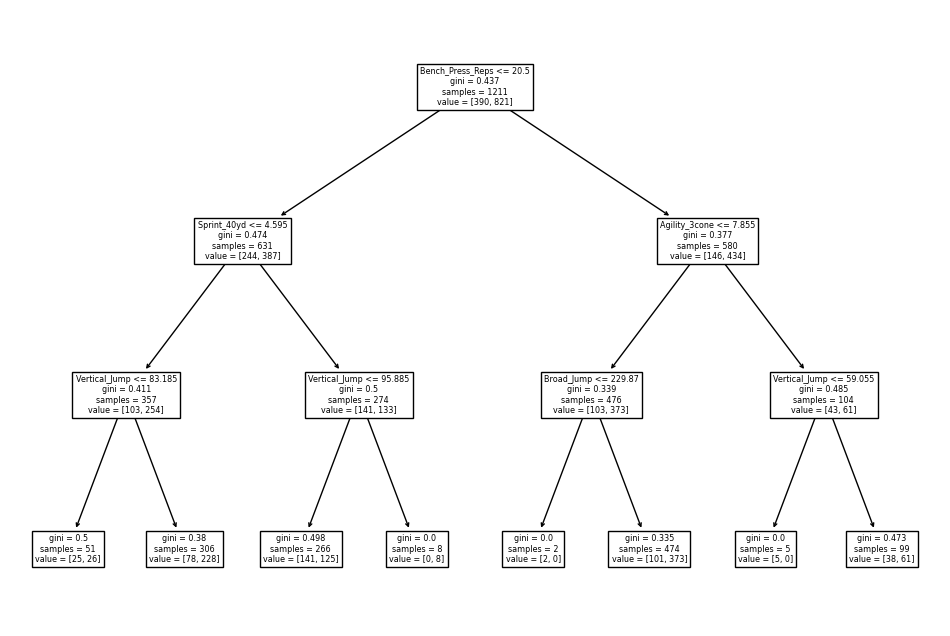

In [75]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(X_train,y_train), feature_names = X_train.columns )
plt.show()

I wouldn't recommend always plotting out this diagram as for very large models, it can become quite time consuming and you will not get much usable information out of it! But it is very useful for understanding how a decision tree works.

## Feature Importance

A very cool feature of a decision tree is the generation of feature importance. Feature importance in a decision tree refers to a measure of how important each feature or input variable is in determining the final output of the tree.

#### Gathering and Visualizing Feature Importance

In [82]:
# let's create a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_train.columns, clf.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

Let's now create a dataframe to show the importances of each feature numerically.

In [83]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,Sprint_40yd,0.324925
1,Vertical_Jump,0.262829
2,Bench_Press_Reps,0.225738
3,Agility_3cone,0.135935
4,Broad_Jump,0.050573
5,Shuttle,0.000000


If you are an avid football fan and combine enthusiast, it would be no surprise to you that 40 yard dash is the most determinant factor in whether or not a player gets drafted!

And let's make a simple visual to illustrate

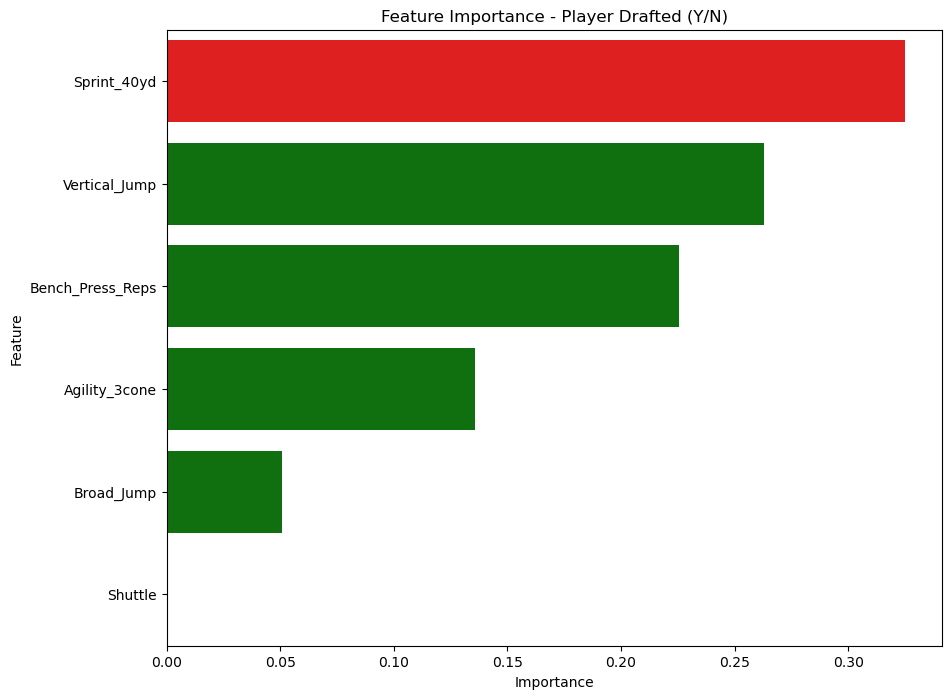

In [84]:
import seaborn as sns
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Feature Importance - Player Drafted (Y/N)')
plt.show()

# Next Steps

This exercise lays the foundation for how to create and evaluate a decision tree classifier. I encourage you to take this dataset and create your own model(s)!

#### Some Ideas:
1. Change/add hyperparameters
2. Build a model for each position and see if that improves accuracy!
3. Maybe try handling missing data differently?



The possibilities here are endless. Get creative and use the tools you've learned thus far!